# 📊 FX Qual Engine — Analytics Notebook
This notebook provides:
- API invocation
- Prometheus metric scraping
- Workflow count visualization
- Step latency visualization
- Load testing
- CSV export

All explanations are in plain English so any developer or manager can understand.

## 🔧 Setup — Imports & Base URL
These imports load Python HTTP client, plotting tools, and helpers. `BASE_URL` points to your running Spring Boot FX Qual Engine.

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import re
import time
import os

BASE_URL = "http://localhost:8080"

## 🔹 API Invocation Helper
This helper sends a POST request to your FX Qual Engine. We pass a simple payload so metrics get generated.

In [2]:
def qualify_fx(client_type="rest_client", amount=1000000):
    url = f"{BASE_URL}/api/fx/qualify?clientType={client_type}"
    payload = {
        "customerId": "CUST001",
        "fromCurrency": "USD",
        "toCurrency": "EUR",
        "quantity": amount,
        "promoCodes": ["FX50"],
        "productCodes": ["FXSPOT"]
    }
    resp = requests.post(url, json=payload)
    return resp.json(), resp.status_code

## 🔹 Prometheus Scraper
This fetches raw Prometheus text and extracts only the lines you need.

In [3]:
def fetch_prometheus():
    return requests.get(f"{BASE_URL}/actuator/prometheus").text

def find_metrics(raw, key):
    return [line for line in raw.split("\n") if key in line]

## 🔹 Metric Parsing → DataFrames
Prometheus exposes timers as `_sum` and `_count`, so we compute average step latency.
This makes graphs readable for humans.

In [4]:
def parse_workflow(lines):
    data = []
    for l in lines:
        if "_count" not in l:
            continue
        value = float(l.split()[-1])
        m = re.search(r'clientImpl="([^"]+)"', l)
        client = m.group(1) if m else "unknown"
        data.append({"clientImpl": client, "count": value})
    return pd.DataFrame(data)

def parse_step_latency(raw_text):
    sum_lines = find_metrics(raw_text, "fxqual_step_duration_ms_seconds_sum")
    count_lines = find_metrics(raw_text, "fxqual_step_duration_ms_seconds_count")

    sums = {}
    counts = {}

    for l in sum_lines:
        m = re.search(r'step="([^"]+)".* ([0-9\.eE+-]+)$', l)
        if m:
            sums[m.group(1)] = float(m.group(2))

    for l in count_lines:
        m = re.search(r'step="([^"]+)".* ([0-9\.eE+-]+)$', l)
        if m:
            counts[m.group(1)] = float(m.group(2))

    rows = []
    for step in sums:
        if step in counts and counts[step] > 0:
            avg_ms = (sums[step] / counts[step]) * 1000
            rows.append({"step": step, "avg_ms": avg_ms})

    return pd.DataFrame(rows)

## 📈 Real-time Workflow Execution Count
This graph shows **how many workflow executions occurred over time**.
Useful to confirm traffic load, spikes, and scaling behavior.

In [5]:
def animate_workflow(i):
    raw = fetch_prometheus()
    wf = find_metrics(raw, "fxqual_workflow_duration_ms_seconds_count")
    df = parse_workflow(wf)
    plt.cla()
    if not df.empty:
        plt.plot(df["count"], marker="o")
    plt.title("Real-Time Workflow Execution Count")
    plt.grid(True)

fig = plt.figure(figsize=(10,4))
ani = animation.FuncAnimation(fig, animate_workflow, interval=2000)
plt.show()

/var/folders/hy/xswqc07s3517h7mybfn63dqw0000gn/T/ipykernel_22240/2551615327.py:12: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, animate_workflow, interval=2000)


<Figure size 1000x400 with 0 Axes>

## 📊 Step Latency Graph (Average ms per API)
This graph shows **how long each downstream call takes on average**.
Developers use this to spot slow services quickly.

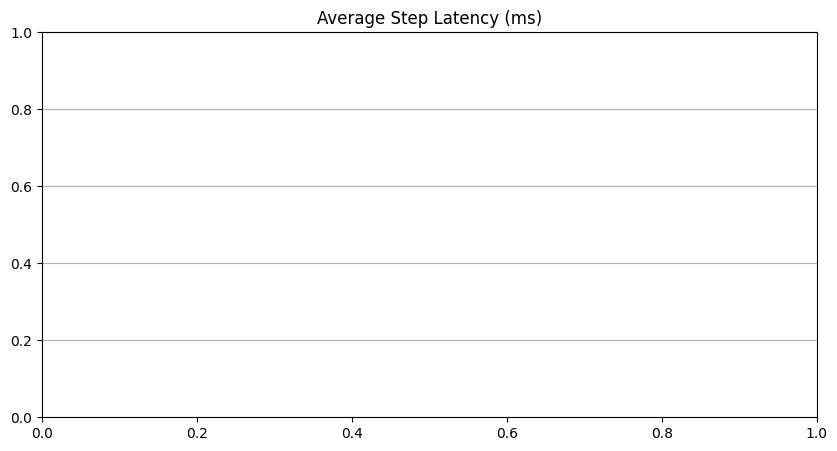

In [6]:
raw = fetch_prometheus()
steps_df = parse_step_latency(raw)

plt.figure(figsize=(10,5))
if not steps_df.empty:
    plt.bar(steps_df["step"], steps_df["avg_ms"])
plt.title("Average Step Latency (ms)")
plt.grid(True, axis="y")
plt.show()

## 🚀 Load Test Helper
This sends repeated API calls to generate meaningful metrics.

In [7]:
def load_test(n=20, client_type="rest_client"):
    for i in range(n):
        qualify_fx(client_type)
        time.sleep(0.1)
    return "Load test complete"

load_test(5)

'Load test complete'

## 📦 Export metrics to CSV
Saves workflow + latency metrics for offline analysis, dashboards, or sharing.

In [8]:
raw = fetch_prometheus()
workflow_df = parse_workflow(find_metrics(raw, "fxqual_workflow_duration_ms_seconds_count"))
steps_df = parse_step_latency(raw)

os.makedirs("exports", exist_ok=True)
workflow_df.to_csv("exports/workflow_metrics.csv", index=False)
steps_df.to_csv("exports/step_metrics.csv", index=False)

workflow_df, steps_df

(             clientImpl  count
 0  FxQualRestClientImpl    5.0,
          step     avg_ms
 0    customer  42.874067
 1  fxInterest   0.003817
 2     product   0.004550
 3       promo   0.004958)